In [200]:
# Library Imports
import os
import random
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima
from keras.layers import Dense, LSTM, TimeDistributed
from keras.models import Sequential

In [201]:
# Data Loading ~1M rows, run time ~7 minutes

# this contains all years
fileName = 'crime.xlsx'

data = pd.read_excel(fileName)

In [202]:
# Data Variables, for easy reference

# one column removed that is dropped in the processing step
data_columns = ['CATEGORY', 'CALL GROUPS', 'final_case_type', 'CASE DESC', 'occ_date', 'x_coordinate', 'y_coordinate', 'census_tract', 'year']

data_category = ['STREET CRIMES', 'OTHER', 'MOTOR VEHICLE THEFT', 'BURGLARY']
 
data_call_groups = ['DISORDER', 'PERSON CRIME', ' SUSPICIOUS', 'NON CRIMINAL/ADMIN', 'PROPERTY CRIME', 'TRAFFIC']

data_case_types = ['DISTP ', 'DISTW ', 'VICE  ', 'ASSLTP', 'ASSLTW', 'ROBP  ',
       'ROBW  ', 'SHOOTW', 'SHOTS ', 'STABW ', 'THRETP', 'THRETW',
       'GANG  ', 'AREACK', 'PREMCK', 'SUSP  ', 'SUSPP ', 'SUSPW ',
       'ANIML ', 'ANIMLP', 'BOMBTH', 'CHEMTH', 'DIST  ', 'ESCAPE',
       'FWB   ', 'FWH   ', 'FWI   ', 'FWN   ', 'NOISE ', 'CHEM  ',
       'PARK  ', 'PARTY ', 'POLINV', 'SCHL  ', 'SCHLP ', 'THRET ',
       'TMET  ', 'TMETP ', 'TRASH ', 'TRASHP', 'UNWNT ', 'TMETW ',
       'UNWNTP', 'UNWNTW', 'W26   ', 'ASSIST', 77, 'CIVIL ', 'EVICT ',
       'FOLLOW', 'MSG   ', 'FLAG  ', 'PROP  ', 'RED   ', 'RIVPOL',
       'SEIZE ', 'SERVE ', 'STNDBY', 'TRANS ', 'WARR  ', 'WARRC ',
       'WELCK ', 'SUBSTP', 'WELCKP', 'ASSLT ', 'DEVICE', 'ROB   ',
       'SHOOT ', 'STAB  ', 'BURG  ', 'FRAUD ', 'FRAUDP', 'THEFT ',
       'IDENT ', 'THEFTC', 'THEFTP', 'VAND  ', 'VANDP ', 'VEHST ',
       'ACCHR ', 'ACCHRP', 'ACCINJ', 'ACCNON', 'ACCUNK', 'DUII  ',
       'HAZARD', 'TRASTP', 'WRONG ', 'FPURS ', 'TPURS ', 'VEHREC',
       'VEHSTP', 'PROWLP', 'BURGP ', 'SCHLW ', 'RSTLN ', 'ZERO  ',
       'GREAT ', 'SCHLET', 'HOSTGE']


In [203]:
# Data processing

# Datetime processing
data['occ_date'] = pd.to_datetime(data['occ_date'])

# Census tract was read as float from excel, fill missing values to 0, convert to int
data['census_tract'].fillna(0, inplace=True)
data['census_tract'] = data['census_tract'].astype(int)

# Storing Census tracts for future reference
# 235 unique census tracks
data_census_tract = data['census_tract'].unique().astype(int)

# RUN ONCE Drop unnecessary column 'Unnamed: 0' -an artifact from the excel import
# data.drop(columns='Unnamed: 0', inplace=True)

# Renaming Category labels for Call Groups -for later use b/c of python naming conventions
# SUSPICIOUS label had a leading space
label_mappings = {'PERSON CRIME': 'PERSON', 'NON CRIMINAL/ADMIN': 'ADMIN', 'PROPERTY CRIME': 'PROPERTY', ' SUSPICIOUS': 'SUSPICIOUS'}

data['CALL GROUPS'] = data['CALL GROUPS'].map(lambda x: label_mappings.get(x, x))

In [204]:
# Data Grouping by Call Groups

# Changing array to match new labels
data_call_groups = ['DISORDER', 'PERSON', 'SUSPICIOUS', 'ADMIN', 'PROPERTY', 'TRAFFIC']

# Creating and aggregating dataframes for each call group type
for i in data_call_groups:
    globals()[i] = data[data['CALL GROUPS'] == i]
    globals()[i] = globals()[i].groupby([data['occ_date'].dt.to_period('M')]).size().reset_index('occ_date')
    globals()[i].rename(columns={0: 'count'}, inplace=True)


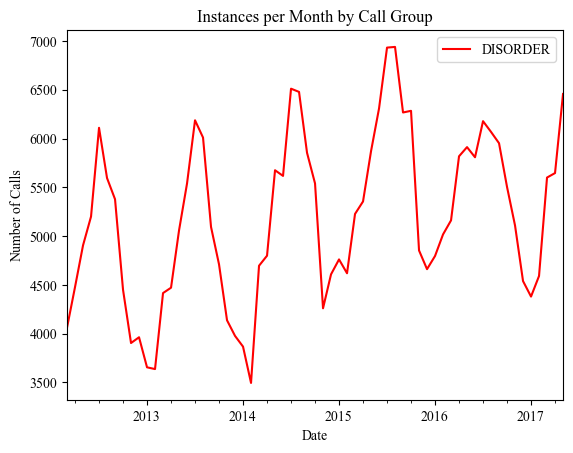

In [232]:
# data visualizations for 'DISORDER'

DISORDER.plot(y='count', x='occ_date', label='DISORDER', color='red')
font = {'family': 'Times New Roman', 'weight': 'normal', 'size': 10}
plt.rc('font', **font)
plt.title('Instances per Month by Call Group')
plt.xlabel('Date')
plt.ylabel('Number of Calls')
plt.legend()
plt.show()

In [ ]:
# data visualizations for 'PERSON', 'SUSPICIOUS', 'ADMIN', 'PROPERTY', 'TRAFFIC'

PERSON.plot(y='count', x='occ_date', label='PERSON', color='blue')
SUSPICIOUS.plot(y='count', x='occ_date', label='SUSPICIOUS', color='black')
ADMIN.plot(y='count', x='occ_date', label='ADMIN', color='orange')
PROPERTY.plot(y='count', x='occ_date', label='PROPERTY', color='purple')
TRAFFIC.plot(y='count', x='occ_date', label='TRAFFIC', color='pink')
plt.title('Instances per Month by Call Group')
plt.xlabel('Date')
plt.ylabel('Number of Calls')
plt.legend()
plt.show()

In [207]:
# Test/Train Data Splitting -ARIMA 
# for 'DISORDER', 'PERSON', 'SUSPICIOUS', 'ADMIN', 'PROPERTY', 'TRAFFIC'

# Split point based on date, ~75/25 split
split_date = '2016-01-01'

for i in data_call_groups:
    globals()['train_data'+ i] = globals()[i][globals()[i]['occ_date'] < split_date]
    globals()['test_data'+ i] = globals()[i][globals()[i]['occ_date'] >= split_date]
    
# printing DISORDER as an example, all train/test data are the same ratio
print(f"Training {len(train_dataDISORDER)}, Test {len(test_dataDISORDER)}")


Training 46, Test 17


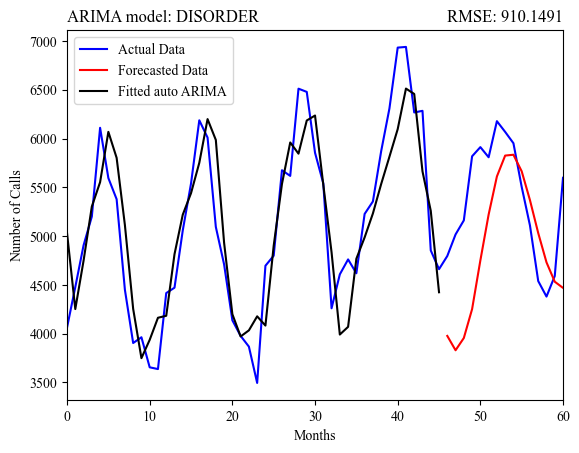

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   46
Model:               SARIMAX(4, 0, 0)   Log Likelihood                -344.357
Date:                Wed, 13 Dec 2023   AIC                            700.713
Time:                        18:30:49   BIC                            711.685
Sample:                             0   HQIC                           704.823
                                 - 46                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   2571.0459    550.936      4.667      0.000    1491.231    3650.861
ar.L1          0.7238      0.159      4.557      0.000       0.412       1.035
ar.L2          0.3479      0.188      1.849      0.0

In [233]:
# ARIMA Model DISORDER

# Using auto arima to find optimized p, d, q values
model = auto_arima(train_dataDISORDER['count'], seasonal = True,
                          error_action ='ignore',
                          stepwise = True)

forecast, conf_int = model.predict(n_periods=17, return_conf_int=True)

plt.plot(DISORDER['count'], label="Actual Data", color="blue")
plt.plot(forecast, color="red", label="Forecasted Data")
plt.plot(model.fittedvalues(), color="black", label="Fitted auto ARIMA")

# Calculating the RMSE (Root Mean Squared Error)
rmse = mean_squared_error(test_dataDISORDER['count'], forecast, squared=False)
rmse_dict = {'DISORDER' : rmse}

# Plotting
font = {'family': 'Times New Roman', 'weight': 'normal', 'size': 10}
plt.rc('font', **font)
plt.xlim(0, 60)
plt.title(f"RMSE: {rmse:.4f}", loc="right")
plt.title("ARIMA model: DISORDER", loc="left")
plt.xlabel('Months')
plt.ylabel('Number of Calls')
plt.legend()
plt.show()
print(model.summary())

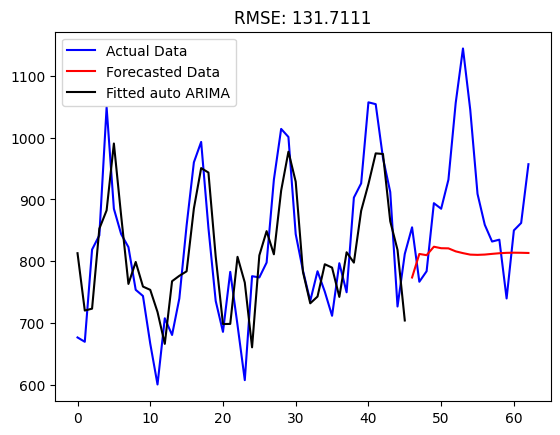

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   46
Model:               SARIMAX(3, 0, 0)   Log Likelihood                -267.166
Date:                Wed, 13 Dec 2023   AIC                            544.331
Time:                        18:06:53   BIC                            553.474
Sample:                             0   HQIC                           547.756
                                 - 46                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    414.8522    108.466      3.825      0.000     202.262     627.442
ar.L1          0.7516      0.138      5.432      0.000       0.480       1.023
ar.L2          0.0678      0.210      0.322      0.7

In [209]:
# ARIMA Model PERSON

# Using auto arima to find optimized p, d, q values
model = auto_arima(train_dataPERSON['count'], seasonal = True,
                          error_action ='ignore',
                          stepwise = True)

forecast, conf_int = model.predict(n_periods=17, return_conf_int=True)

plt.plot(PERSON['count'], label="Actual Data", color="blue")
plt.plot(forecast, color="red", label="Forecasted Data")
plt.plot(model.fittedvalues(), color="black", label="Fitted auto ARIMA")

# Calculating the RMSE (Root Mean Squared Error)
rmse = mean_squared_error(test_dataPERSON['count'], forecast, squared=False)
rmse_dict['PERSON'] = rmse

# Plotting
plt.title(f"RMSE: {rmse:.4f}")
plt.legend()
plt.show()
print(model.summary())

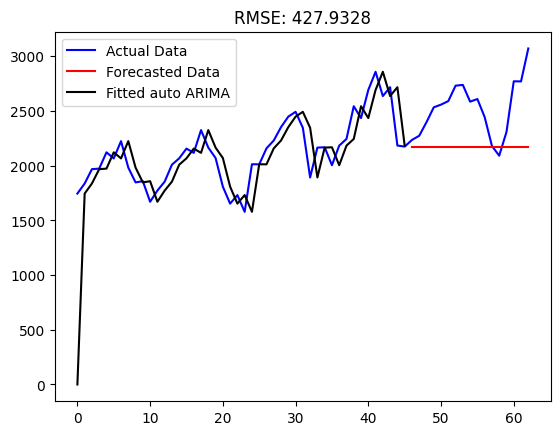

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   46
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -299.390
Date:                Wed, 13 Dec 2023   AIC                            600.781
Time:                        18:06:54   BIC                            602.588
Sample:                             0   HQIC                           601.454
                                 - 46                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.517e+04   6535.032      5.382      0.000    2.24e+04     4.8e+04
Ljung-Box (L1) (Q):                   0.73   Jarque-Bera (JB):                 3.50
Prob(Q):                              0.39   Pr

In [210]:
# ARIMA Model SUSPICIOUS

# Using auto arima to find optimized p, d, q values
model = auto_arima(train_dataSUSPICIOUS['count'], seasonal = True,
                          error_action ='ignore',
                          stepwise = True)

forecast, conf_int = model.predict(n_periods=17, return_conf_int=True)

plt.plot(SUSPICIOUS['count'], label="Actual Data", color="blue")
plt.plot(forecast, color="red", label="Forecasted Data")
plt.plot(model.fittedvalues(), color="black", label="Fitted auto ARIMA")

# Calculating the RMSE (Root Mean Squared Error)
rmse = mean_squared_error(test_dataSUSPICIOUS['count'], forecast, squared=False)
rmse_dict['SUSPICIOUS'] = rmse

# Plotting
plt.title(f"RMSE: {rmse:.4f}")
plt.legend()
plt.show()
print(model.summary())

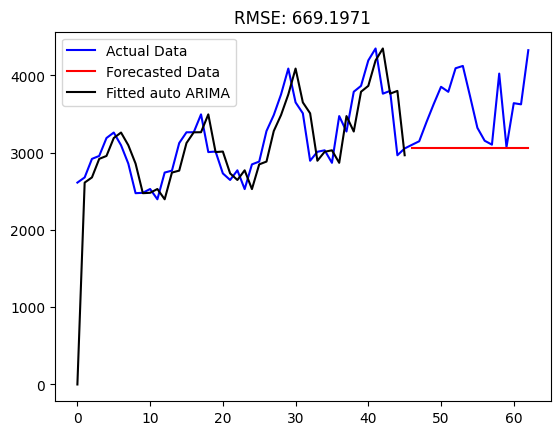

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   46
Model:               SARIMAX(0, 1, 0)   Log Likelihood                -320.593
Date:                Wed, 13 Dec 2023   AIC                            643.186
Time:                        18:06:54   BIC                            644.993
Sample:                             0   HQIC                           643.859
                                 - 46                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      9.025e+04    1.8e+04      5.009      0.000    5.49e+04    1.26e+05
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):                 3.16
Prob(Q):                              0.64   Pr

In [211]:
# ARIMA Model ADMIN

# Using auto arima to find optimized p, d, q values
model = auto_arima(train_dataADMIN['count'], seasonal = True,
                          error_action ='ignore',
                          stepwise = True)

forecast, conf_int = model.predict(n_periods=17, return_conf_int=True)

plt.plot(ADMIN['count'], label="Actual Data", color="blue")
plt.plot(forecast, color="red", label="Forecasted Data")
plt.plot(model.fittedvalues(), color="black", label="Fitted auto ARIMA")

# Calculating the RMSE (Root Mean Squared Error)
rmse = mean_squared_error(test_dataADMIN['count'], forecast, squared=False)
plt.title(f"RMSE: {rmse:.4f}")
rmse_dict['ADMIN'] = rmse

# Plotting
plt.legend()
plt.show()
print(model.summary())

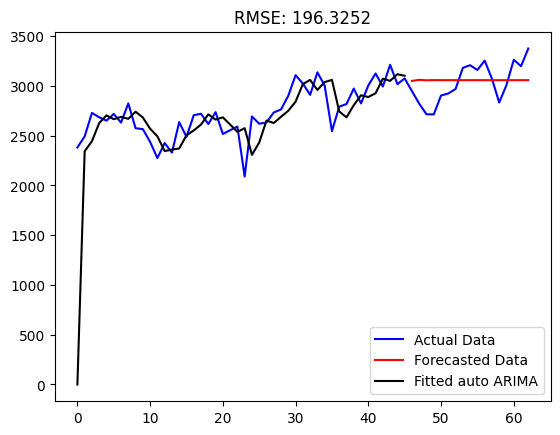

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   46
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -296.802
Date:                Wed, 13 Dec 2023   AIC                            597.605
Time:                        18:06:56   BIC                            601.218
Sample:                             0   HQIC                           598.952
                                 - 46                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4337      0.120     -3.600      0.000      -0.670      -0.198
sigma2      3.151e+04   5426.308      5.806      0.000    2.09e+04    4.21e+04
Ljung-Box (L1) (Q):                   0.38   Jarque-

In [212]:
# ARIMA Model PROPERTY

# Using auto arima to find optimized p, d, q values
model = auto_arima(train_dataPROPERTY['count'], seasonal = True,
                          error_action ='ignore',
                          stepwise = True)

forecast, conf_int = model.predict(n_periods=17, return_conf_int=True)

plt.plot(PROPERTY['count'], label="Actual Data", color="blue")
plt.plot(forecast, color="red", label="Forecasted Data")
plt.plot(model.fittedvalues(), color="black", label="Fitted auto ARIMA")

# Calculating the RMSE (Root Mean Squared Error)
rmse = mean_squared_error(test_dataPROPERTY['count'], forecast, squared=False)
rmse_dict['PROPERTY'] = rmse

# Plotting
plt.title(f"RMSE: {rmse:.4f}")
plt.legend()
plt.show()
print(model.summary())

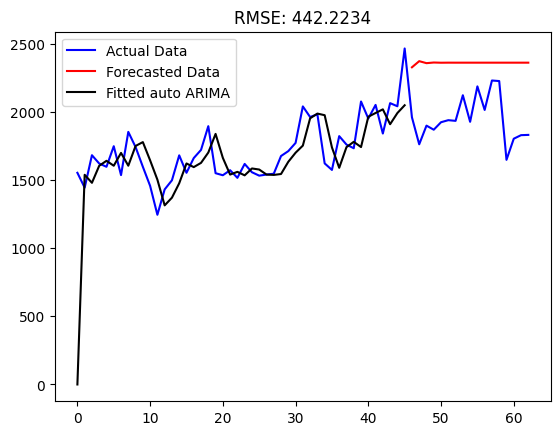

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   46
Model:               SARIMAX(1, 1, 0)   Log Likelihood                -293.221
Date:                Wed, 13 Dec 2023   AIC                            590.442
Time:                        18:06:57   BIC                            594.055
Sample:                             0   HQIC                           591.789
                                 - 46                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3256      0.199     -1.637      0.102      -0.715       0.064
sigma2      2.673e+04   5780.711      4.625      0.000    1.54e+04    3.81e+04
Ljung-Box (L1) (Q):                   0.00   Jarque-

In [213]:
# ARIMA Model TRAFFIC

# Using auto arima to find optimized p, d, q values
model = auto_arima(train_dataTRAFFIC['count'], seasonal = True,
                          error_action ='ignore',
                          stepwise = True)

forecast, conf_int = model.predict(n_periods=17, return_conf_int=True)

plt.plot(TRAFFIC['count'], label="Actual Data", color="blue")
plt.plot(forecast, color="red", label="Forecasted Data")
plt.plot(model.fittedvalues(), color="black", label="Fitted auto ARIMA")

# Calculating the RMSE (Root Mean Squared Error)
rmse = mean_squared_error(test_dataTRAFFIC['count'], forecast, squared=False)
plt.title(f"RMSE: {rmse:.4f}")
rmse_dict['TRAFFIC'] = rmse

# Plotting
plt.legend()
plt.show()
print(model.summary())

In [216]:
# LSTM Model Building

model = Sequential([
    LSTM(20, return_sequences=True, input_shape= [None, 1]),
    LSTM(20, return_sequences=True),
    TimeDistributed(Dense(10))
])

In [236]:
# Model Evaluations

for key, value in rmse_dict.items():
    print(f"Model: {key}, RSME: {value:.2f}")

Model: DISORDER, RSME: 910.15
